<a href="https://colab.research.google.com/github/kimsooyoung/practical_jetson_examples/blob/main/Digits%20Recognition%20with%20MNIST/%5BPractical%20Jetson%20%231-2%5D%20Digits_Recognition_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical Exercise with MNIST Example #1-2 - "Predict Part"**

**[!important] Check your Runtime type bf running this example (Runtime > Change runtime type)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import easydict

# Colab only
from google.colab.patches import cv2_imshow

# **GPU usability check**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# **Same Model as Before**

In [ ]:
# @title
class Block(nn.Module):

    def __init__(self,
                input_size,
                output_size,
                use_batch_norm=True,
                dropout_p=.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularizer(use_batch_norm, size):
            # BatchNorm1d: Convert one MNIST dataset into 784 dim vector (784 means node for fully connected layer)
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)

        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )

    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        # |y| = (batch_size, output_size)

        return y

class ImageClassifier(nn.Module):

    def __init__(self,
                input_size,
                output_size,
                hidden_sizes=[500, 400, 300, 200, 100],
                use_batch_norm=True,
                dropout_p=.4):

        super().__init__()

        assert len(hidden_sizes) > 0, "You need to specify hidden layers"

        last_hidden_size = input_size
        blocks = []
        for hidden_size in hidden_sizes:
            blocks += [Block(
                last_hidden_size,
                hidden_size,
                use_batch_norm,
                dropout_p
            )]
            last_hidden_size = hidden_size

        self.layers = nn.Sequential(
            *blocks,
            nn.Linear(last_hidden_size, output_size),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.layers(x)
        # |y| = (batch_size, output_size)

        return y

# **Also Same DataLoader as Before**

In [ ]:
# @title
def load_mnist(is_train=True, flatten=True):

    dataset = datasets.MNIST('../data',      # ../data: path for MNIST Dataset
        train=is_train,               # is_train  load train dataset for True, load test dataset for False
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),         # convert image info tensor using transforms.ToTensor()
        ]),
    )

    x = dataset.data.float() / 255.   # / 255 : From 255 level pixel value into 0-1 scale
    y = dataset.targets               # ground truth tensor

    if flatten:
        x = x.view(x.size(0), -1)    # 28*28 = 784 (2D image into 1D vector)

    return x, y


def split_data(x, y, train_ratio=.8):

    train_cnt = int(x.size(0) * train_ratio)
    valid_cnt = x.size(0) - train_cnt

    # Shuffle dataset to split into train/valid set.
    indices = torch.randperm(x.size(0))
    x = torch.index_select(
        x,
        dim=0,
        index=indices
    ).split([train_cnt, valid_cnt], dim=0)

    y = torch.index_select(
        y,
        dim=0,
        index=indices
    ).split([train_cnt, valid_cnt], dim=0)

    return x, y


def get_hidden_sizes(input_size, output_size, n_layers):
    step_size = int((input_size - output_size) / n_layers)

    hidden_sizes = []
    current_size = input_size
    for i in range(n_layers - 1):
        hidden_sizes += [current_size - step_size]
        current_size = hidden_sizes[-1]

    return hidden_sizes


## **Funtions for Result Test**

**[!important] You must have to import a trained `.pth` file in this workspace!**

In [ ]:
import os.path
file = './model_test.pth'

if os.path.isfile(file):
  print("Model File Found Keep Going :)")
else:
  print("[ERROR] No Model File Found :(")

Model File Found Keep Going :)


* **helper functions for result validating**

In [ ]:
# trained model file name and path
model_fn = "./model_test.pth"

# Loads an object saved with torch.save() from a file.
def load(fn, device):

    d = torch.load(fn, map_location=device)

    return d['model'], d['config']

# visualize input image and prediction result.
def plot(x, y_hat):

    for i in range(x.size(0)):
        img = (np.array(x[i].detach().cpu(), dtype='float')).reshape(28,28)
        print(y_hat[i])
        plt.imshow(img, cmap='gray')
        plt.show()
        print("Predict:", float(torch.argmax(y_hat[i], dim=-1)))

* **Accuracy Test function**

In [ ]:
def test(model, x, y, to_be_shown=True):
    model.eval()

    with torch.no_grad(): # loss packprop should be halt during testing

        y_hat = model(x)

        # y: long tensor  # y_hat: log scale prob value
        correct_cnt = (y.squeeze() == torch.argmax(y_hat, dim=-1)).sum()
        total_cnt = float(x.size(0))

        accuracy = correct_cnt / total_cnt
        print("Accuracy: %.4f" % accuracy)

        if to_be_shown:
            plot(x, y_hat)

## **Model Evaluation Main Loop**

In [ ]:
# Load MNIST test set.
x, y = load_mnist(is_train=False)
# 2D image into 1D vector
x = x.view(x.size(0), -1)

# move tensor values into GPU
x, y = x.to(device), y.to(device)

# input image size : 784 (=28*28)
# output class : 10 (0 to 9)
input_size = int(x.shape[-1])
output_size = int(max(y)) + 1

# load model and configuration
model_dict, train_config = load(model_fn, device)
# define same model as previous prediction model
model = ImageClassifier(
    input_size=input_size,
    output_size=output_size,
    hidden_sizes=get_hidden_sizes(input_size,
                                output_size,
                                train_config.n_layers),
    use_batch_norm=not train_config.use_dropout,
    dropout_p=train_config.dropout_p,
).to(device)

# load trained params
model.load_state_dict(model_dict)

# Final test Execution!
test(model, x, y, to_be_shown=False)

Accuracy: 0.9785


Accuracy: 1.0000
tensor([-1.5789e+01, -1.4968e+01, -1.0907e+01, -1.4230e+01, -1.5390e+01,
        -1.7838e+01, -2.6334e+01, -5.4358e-05, -1.8675e+01, -1.0273e+01],
       device='cuda:0')


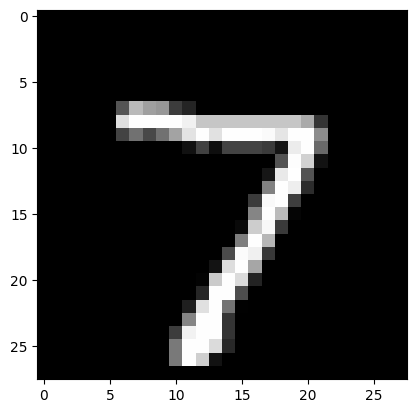

Predict: 7.0
tensor([-1.3483e+01, -1.0697e+01, -3.9100e-05, -1.2147e+01, -1.4108e+01,
        -1.8407e+01, -1.5569e+01, -1.1779e+01, -1.3635e+01, -2.0423e+01],
       device='cuda:0')


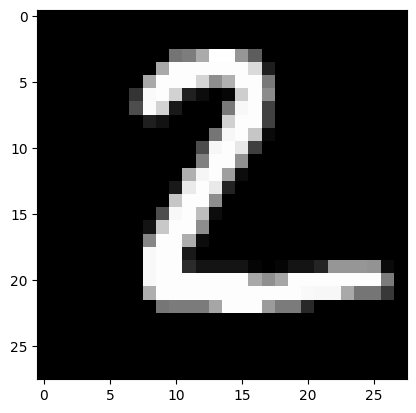

Predict: 2.0


In [ ]:
# display 2 among total 10000 dataset
n_test = 2
test(model, x[:n_test], y[:n_test], to_be_shown=True)

## **Handwritten Digit Recognition - You can use your own image here!**

* image pre-processing before inference

In [ ]:
def preprocess_image(image_path):
    # color to grayscale
    img_color = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # Image Thresholding : https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    ret,img_binary = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Morphological Transformations : https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html
    kernel = cv2.getStructuringElement( cv2.MORPH_RECT, ( 5, 5 ) )
    img_binary = cv2.morphologyEx(img_binary, cv2. MORPH_CLOSE, kernel)

    # visualization for validation
    cv2_imshow(img_binary)

    # Resize image as the model input
    img_binary = cv2.resize(img_binary, (28, 28), interpolation=cv2.INTER_AREA)

    # Image to torch.Tensor
    img_binary = torch.tensor(img_binary, dtype=torch.float32)

    # Normalize and channel addition
    img_binary = img_binary.unsqueeze(0).unsqueeze(0) / 255.0

    # 2D image into 1D
    img_binary = img_binary.view(1, -1)
    print(img_binary.size())

    return img_binary

## **Change image path/name and run prediction!**

**[!important] You must specify image file name and path in this workspace!**


In [ ]:
import os.path

image_path = './test_6.jpg'
# image_path = './capture_8.jpg'

if os.path.isfile(image_path):
  print("Image File Found Keep Going :)")
else:
  print("[ERROR] No Image File :(")

Image File Found Keep Going :)


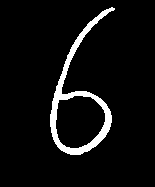

torch.Size([1, 784])
Predicted Output: tensor([[-1.1226e+01, -1.4619e+01, -1.5825e+01, -1.8205e+01, -1.2518e+01,
         -8.1789e+00, -3.5029e-04, -2.1673e+01, -9.8613e+00, -1.8179e+01]],
       device='cuda:0')
The predicted number is: 6


In [ ]:
def predict(image_path):
    image = preprocess_image(image_path)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)

    _, predicted = torch.max(output, 1)
    print(f'Predicted Output: {output}')
    return predicted.item()

result = predict(image_path)
print(f'The predicted number is: {result}')

--------------